# Illustrate the iEGM through the Buffer-Stock Model

## Monte Carlo Settings

In [10]:
MC_num = 10 # number of Monte Carlo simulations
C_num_grid = (10,20,50,100,200) # number of grid points in consumption grid i iEGM
specs = { # common specifications across methods
    'rho':1.5,

    'max_C':5.0,
    'max_m':5.0,

    'num_m':200,
    'T': 20,

    'simN':10_000,

} 


MC_num = 10 # number of Monte Carlo simulations
C_num_grid = (10,20,50,100,200) # number of grid points in consumption grid i iEGM
specs = { # common specifications across methods
    'rho':1.5,

    'max_C':5.0,
    'max_m':5.0,

    'num_m':100,
    'T': 20,

    'simN':1_000,

} 

## Load relevant packages

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from BufferStockModel import BufferStockModelClass

plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Illustrate the pre-computation of consumption interpolator

In [12]:
# load local model file and initialize model class
SAVE = True
specs_illustrate = {
    'rho':1.5,

    'num_C':10,
    'max_C':5.0,
    'unequal_C':1.5,
}

model = BufferStockModelClass(par=specs_illustrate)
par = model.par

# pre-compute consumption
model.precompute_C()

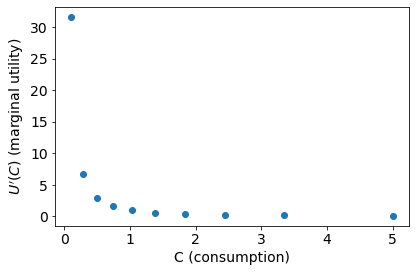

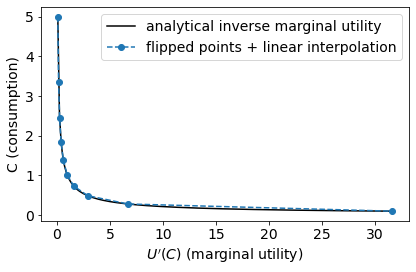

In [13]:
# illustrate the iEGM pre-computation
fig, ax = plt.subplots()
ax.scatter(par.grid_C,par.grid_marg_U)
ax.set(xlabel='C (consumption)',ylabel="$U\'(C)$ (marginal utility)");
fig.tight_layout()
fig.savefig('output/fig_illustrate_flip1.pdf')

fig, ax = plt.subplots()
fine_grid = np.linspace(par.grid_marg_U_flip[0],par.grid_marg_U_flip[-1],200)
ax.plot(fine_grid,model.inv_marg_util(fine_grid),color='black',label='analytical inverse marginal utility')
ax.plot(par.grid_marg_U_flip,par.grid_C_flip,marker='o',linestyle='--',color='tab:blue',label='flipped points + linear interpolation');
ax.set(xlabel='$U\'(C)$ (marginal utility)',ylabel="C (consumption)");
ax.legend();
fig.tight_layout()
if SAVE: fig.savefig('output/fig_illustrate_flip2.pdf')

## Solve the model using VFI, EGM and iEGM

In [14]:
specs_now = {
    'rho':1.5,

    'num_C':100,
    'max_C':5.0,
    'max_m':5.0,

    'num_m':50,
    'T': 20,

    'simN':10_000,
}

model = BufferStockModelClass(par=specs_now)

In [27]:
# model.par.method='vfi'
# print(f'{model.par.method}:')
# %timeit model.solve()

# model.simulate()
# print(f'avg. log10 Euler error: {model.sim.mean_log10_euler:.3f} \n')


# model.par.method='egm'
# model.par.interp_inverse = False
# print(f'{model.par.method}:')
# %timeit model.solve()

# model.simulate()
# print(f'avg. log10 Euler error: {model.sim.mean_log10_euler:.3f} \n')


# model.par.method='iegm'
# model.par.interp_method = 'linear'
# model.par.interp_inverse = False
# print(f'{model.par.method}:')
# %timeit model.solve()

# model.simulate()
# print(f'avg. log10 Euler error: {model.sim.mean_log10_euler:.3f} \n')


# model.par.method='iegm'
# model.par.interp_method = 'regression'
# model.par.interp_inverse = False
# print(f'{model.par.method}, regression:')
# %timeit model.solve()

# model.simulate()
# print(f'avg. log10 Euler error: {model.sim.mean_log10_euler:.3f} \n')


# model.par.method='iegm'
# model.par.interp_method = 'linear'
# model.par.interp_inverse = True
# print(f'{model.par.method}, inverse:')
# %timeit model.solve()

# model.simulate()
# print(f'avg. log10 Euler error: {model.sim.mean_log10_euler:.3f} \n')


# model.par.method='iegm'
# model.par.interp_method = 'regression'
# model.par.interp_inverse = True
# print(f'{model.par.method}, inverse regression:')
# %timeit model.solve()

# model.simulate()
# print(f'avg. log10 Euler error: {model.sim.mean_log10_euler:.3f} \n')

vfi:
1.83 s ± 518 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
avg. log10 Euler error: -3.306 

egm:
216 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
avg. log10 Euler error: -4.238 



In [ ]:
3.89 s ± 445 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
avg. log10 Euler error: -3.263 

In [16]:
stop

NameError: name 'stop' is not defined

Monte Carlo Runs

In [ ]:
PRINT = True
# setup Monte Carlo results containers
timing = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),

    'iegm, regression':dict(),
    'iegm, regression inverse':dict(),
}
error = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
    
    'iegm, regression':dict(),
    'iegm, regression inverse':dict(),
}
for i_c,num_C in enumerate(C_num_grid):
    timing['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, regression'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, regression'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, regression inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, regression inverse'][num_C] = np.nan + np.zeros(MC_num)

# loop over Monte Carlo simulations
for i_mc in range(MC_num):
    if PRINT: print(f'{i_mc+1}/{MC_num} running...')
    model = BufferStockModelClass(par=specs)
    model.par.seed = i_mc
    model.allocate()

    # VFI and EGM
    for method in ['vfi','egm']:
        model.par.method = method
        
        # Timing
        t0 = time()
        model.solve()
        timing[model.par.method][i_mc] = time() - t0

        # Euler error
        model.simulate()
        error[model.par.method][i_mc] = model.sim.mean_log10_euler

    # iEGM
    model.par.method = 'iegm'
    for interp_method in ('linear','regression'):
        for interp_inverse in (False,True):
            if not ((interp_method=='regression') & (interp_inverse==False)): # only use inverse for regression.
                model.par.interp_method = interp_method
                model.par.interp_inverse = interp_inverse
                method = f'{model.par.method}, {interp_method} inverse' if interp_inverse else f'{model.par.method}, {interp_method}'
                for i_c,num_C in enumerate(C_num_grid):
                    model.par.num_C = num_C
                    model.allocate()

                    # Timing
                    t0 = time()
                    model.solve()
                    timing[method][num_C][i_mc] = time() - t0

                    # Euler error
                    model.simulate()
                    error[method][num_C][i_mc] = model.sim.mean_log10_euler


1/10 running...2/10 running...3/10 running...4/10 running...5/10 running...6/10 running...7/10 running...8/10 running...9/10 running...10/10 running...

In [ ]:
# print('Timing (rel. to VFI)')
# timing_vfi = np.mean(timing['vfi'])
# for method in ['vfi','egm']:
#     time_now = np.mean(timing[method]) / timing_vfi
#     print(f'{method}: {time_now:2.2f} ')

        
# for method in ('iegm','iegm, inverse'):
#     print(f'{method}: ')
#     for i_c,num_C in enumerate(C_num_grid):
#         time_now = np.mean(timing[method][num_C]) / timing_vfi
#         print(f'{num_C:d}: {time_now:2.2f} ')

In [ ]:
print('Euler Error & Timing (rel. to VFI)')
timing_vfi = np.mean(timing['vfi'])
for method in ('vfi','egm'):
    error_now = np.mean(error[method])
    time_now = np.mean(timing[method]) / timing_vfi
    print(f'{method}: {error_now:2.3f} & {time_now:2.3f} ')

for method in ('iegm, linear','iegm, linear inverse','iegm, regression inverse'):
    print(f'{method}: ')
    for i_c,num_C in enumerate(C_num_grid):
        error_now = np.mean(error[method][num_C]) 
        time_now = np.mean(timing[method][num_C]) / timing_vfi
        print(f'{num_C:d} {error_now:2.3f} & {time_now:2.3f} ')

Euler Error & Timing (rel. to VFI)
vfi: -3.486 & 1.000 
egm: -4.934 & 0.052 
iegm, linear: 
10 -1.951 & 0.051 
20 -1.937 & 0.052 
50 -3.027 & 0.047 
100 -3.699 & 0.051 
200 -4.414 & 0.051 
iegm, linear inverse: 
10 -2.624 & 0.050 
20 -2.668 & 0.048 
50 -3.786 & 0.050 
100 -4.466 & 0.056 
200 -4.934 & 0.050 
iegm, regression inverse: 
10 -2.680 & 0.063 
20 -2.819 & 0.068 
50 -2.592 & 0.064 
100 -2.083 & 0.065 
200 -2.450 & 0.072 
